In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt

dev = qml.device('default.mixed', wires= 1)

# == Hamiltonian setup ==
coeffs = [1]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

print('Hamiltonian:', hamiltonian,'\n')

Hamiltonian:   (1) [Z0] 



In [2]:
# Variable
gamma = 0.0001
t = 0


# == damping coeff ==
t1, t2 = 1, 1

# Create a QNode with the quantum circuit and noise model
@qml.qnode(dev)
def circuit(phi):
    
    qml.Hadamard(wires = 0)
    
    # -phi/2 => fixed
    time  = -phi/2
    qml.ApproxTimeEvolution(hamiltonian, time, 1)
    
    qml.AmplitudeDamping(np.exp(-t1/t2), wires=0)
    
    # qml.RZ(-t/2, wires=0)    
    # qml.PhaseShift(-t/2, wires = 0)
    
    # qml.Hadamard(wires = 0)
    
    
    
    return qml.density_matrix(wires=0)
    # return qml.expval(qml.PauliZ(0))

In [3]:
circuit(np.pi/4)

array([[0.68393972+0.j        , 0.28109619+0.28109619j],
       [0.28109619-0.28109619j, 0.31606028+0.j        ]])

In [4]:
def rho_without_kraus(phi):
    state = np.array([ [1+np.exp(-1.j * phi)], [1-np.exp(-1.j*phi)] ]) / 2
    
    rho = state @ state.conj().T
    
    return rho

# density matrix after Hadamard  
def rho_after_kraus(phi):
    
    after_Hada = np.array([ [1+np.exp(-t)*np.cos(phi), -1.j*np.exp(-t)*np.sin(phi)], [1.j*np.exp(-t)*np.sin(phi), 1-np.exp(-t)*np.cos(phi)] ]) / 2
    # kraus = np.array([ [np.sqrt(1-gamma), 0], [0, 1] ])
    kraus = np.array([ [1, 0], [0, np.sqrt(1-gamma)] ])
    
    result = (kraus @ after_Hada @ kraus.conj().T) / (np.trace(kraus @ kraus.conj().T @ after_Hada))
    mem = result
    
    return after_Hada

def rho_after_evo(phi):
    rho_evo = np.array([ [1, np.exp(1.j * phi - t1/t2)], [np.exp(-1.j * phi - t1/t2), 1] ])/2
    
    return rho_evo

rho_after_evo(np.pi / 4)

tensor([[0.5       +0.j        , 0.13006502+0.13006502j],
        [0.13006502-0.13006502j, 0.5       +0.j        ]], requires_grad=True)

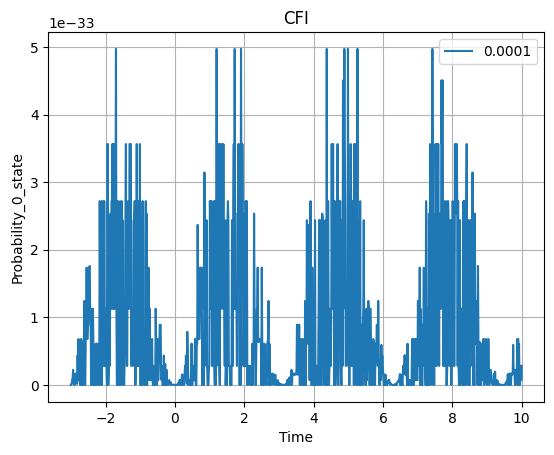

In [5]:
#  == Plot for CFI ==
N = 1000
tau_CFI = np.linspace(-3, 10, N)
# tau_CFI = np.linspace(-0.001, 6.2, N)

CFI_numpy = np.zeros(N)

for i in range(len(tau_CFI)):
    CFI_numpy[i] = (qml.qinfo.classical_fisher(circuit)(tau_CFI[i]))
    # Casting to numpy array without gradient
    # CFI_numpy[i] = round((CFI_numpy[i]).numpy(), 5)


plt.subplot()
plt.plot(tau_CFI, CFI_numpy, label = gamma)
plt.title('CFI')
plt.xlabel('Time')
plt.ylabel('Probability_0_state')
plt.legend()
plt.grid()

In [6]:
def kraus(gamma):
    k = np.array([ [np.sqrt(1-gamma), 0], [0, 1] ])
    
    return k

U = qml.AmplitudeDamping(0.5, wires = 1)

print(U.kraus_matrices()[0].conj())

[[1.         0.        ]
 [0.         0.70710678]]


$\begin{bmatrix}
1 & 0 \\
0 & \sqrt{1-p} 
\end{bmatrix}  $

for p = 0.5:
$\begin{bmatrix}
1 & 0 \\
0 & \sqrt{0.5} 
\end{bmatrix}  $



= $\begin{bmatrix}
1 & 0 \\
0 & 0.707 
\end{bmatrix}  $
